# Face emotions detection using fast.ai framework

*credits to [fast-ai course-v3](https://github.com/fastai/course-v3)*

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from tqdm import tqdm
np.random.seed(42)

## Download images

images urls have been extracted from **google.com** and saved in '.txt' for each category.

Let's read these files and download the corresponding images using the fast.ai tool **download_images**

In [4]:
import os
groups = [{'file': i, 'class': i.split('.')[0]} for i in os.listdir('data') if '.txt' in i]
groups

[{'file': 'thinking.txt', 'class': 'thinking'},
 {'file': 'flexing.txt', 'class': 'flexing'},
 {'file': 'surprise.txt', 'class': 'surprise'},
 {'file': 'smiling.txt', 'class': 'smiling'},
 {'file': 'laughing.txt', 'class': 'laughing'},
 {'file': 'frown.txt', 'class': 'frown'},
 {'file': 'duck.txt', 'class': 'duck'},
 {'file': 'tongue.txt', 'class': 'tongue'},
 {'file': 'crying.txt', 'class': 'crying'}]

In [5]:
import os
groups = [{'file': i, 'class': i.split('.')[0]} for i in os.listdir('data')]

In [6]:
for g in groups:
    dest = Path('data')/g['class']
    input_file = Path('data')/g['file']
    dest.mkdir(parents=True, exist_ok=True)
    download_images(input_file, dest, max_pics=1000)

IsADirectoryError: [Errno 21] Is a directory: 'data/smiling'

Fast.ai tool **verify_images** is very useful to delete all files in a given folder that can not be opened as an image.

In [ ]:
for g in groups:
    c = g['class']
    print(c)
    dest = Path('data')/g['class']
    input_file = Path('data')/g['file']
    verify_images(dest, delete=True, max_workers=8)

## Load images

In [7]:
path = Path('data')

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)
print(f'Training size: {len(data.train_ds)}')
print(f'Valid size: {len(data.valid_ds)}')
print(f'There is no test set')
print(f'{data.c} classes found: {data.classes}')


Training size: 4142
Valid size: 1072
There is no test set
9 classes found: ['crying', 'duck', 'flexing', 'frown', 'laughing', 'smiling', 'surprise', 'thinking', 'tongue']


Good! Let's take a look at some of our pictures then.

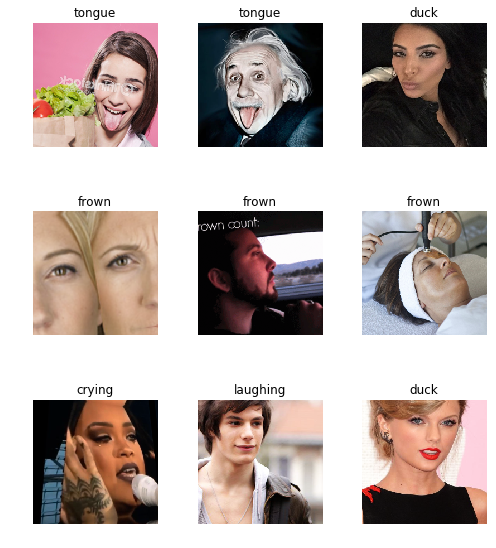

In [8]:
data.show_batch(rows=3, figsize=(7,8))

We can see that our training dataset is very noisy and has a lot of images with wrong labels 

## Train model

In [9]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [10]:
learn.fit_one_cycle(10)
stage1_path = learn.save('stage-1', return_path=True)
print(stage1_path)

Total time: 10:01
epoch  train_loss  valid_loss  error_rate
1      2.394958    1.820193    0.644590    (01:02)
2      2.019765    1.671061    0.566231    (00:59)
3      1.786453    1.624465    0.549440    (00:59)
4      1.639422    1.533000    0.530784    (00:58)
5      1.518717    1.488593    0.499067    (00:59)
6      1.398281    1.473057    0.495336    (01:01)
7      1.300248    1.460934    0.490672    (00:59)
8      1.190701    1.452215    0.483209    (01:00)
9      1.141872    1.443848    0.474813    (00:59)
10     1.101515    1.446777    0.477612    (01:00)

data/models/stage-1.pth


In [ ]:
learn.unfreeze()
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,8e-5))
stage2_path = learn.save('stage-2', return_path=True)
stage2_path

Total time: 04:09
epoch  train_loss  valid_loss  error_rate
1      1.178340    1.489676    0.530669    (01:01)
2      1.142964    1.469815    0.512082    (01:02)
3      1.099970    1.460056    0.507435    (01:03)
4      1.089616    1.456331    0.500929    (01:02)



PosixPath('data/models/stage-2.pth')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


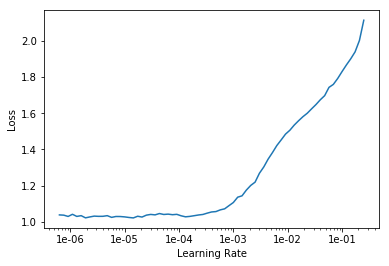

In [55]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.save('stage-2')

## Interpretation

In [60]:
learn.load('stage-1')

In [61]:
interp = ClassificationInterpretation.from_learner(learn)

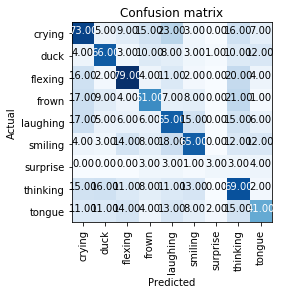

In [62]:
interp.plot_confusion_matrix()

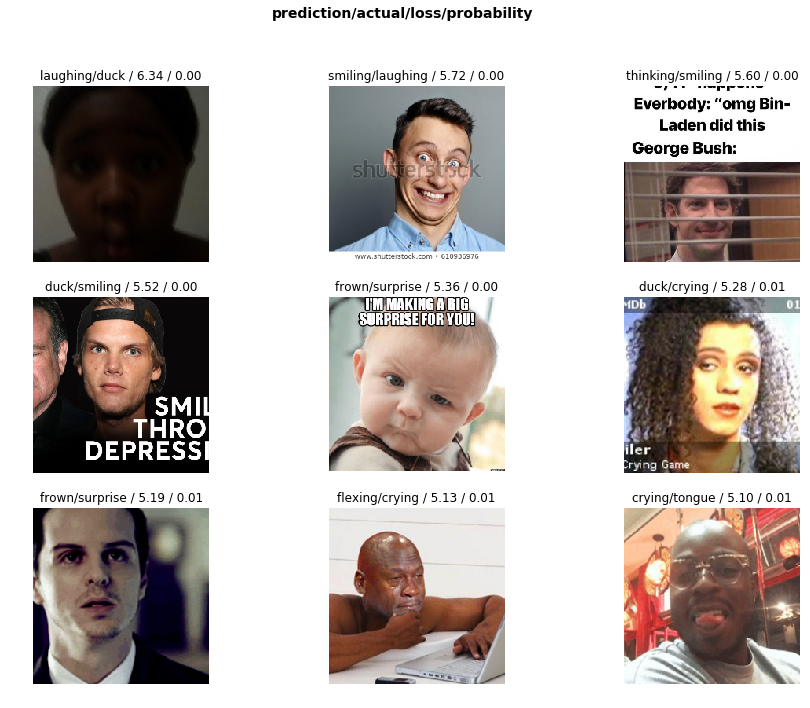

In [63]:
interp.plot_top_losses(9, figsize=(15,11))

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `FileDeleter` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. Here's a handy function that pulls out all our top_losses:

In [71]:
data.valid_ds[0]

(Image (3, 224, 224), 0)

In [64]:
from fastai.widgets import *

losses,idxs = interp.top_losses()
top_loss_paths = data.valid_ds.x[idxs]

Now we can pass in these paths to our widget.

In [67]:
doc(FileDeleter)

In [73]:
fastai.__version__

'1.0.19'

In [66]:
fd = FileDeleter(file_paths=top_loss_paths)

Button(button_style='primary', description='Confirm', style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Confirm' to delete flagged photos and keep the rest in that row. The `File_Deleter` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses`.

In [ ]:
fast

## Putting your model in production

In [ ]:
data.classes

['black', 'grizzly', 'teddys']

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [ ]:
# fastai.defaults.device = torch.device('cpu')

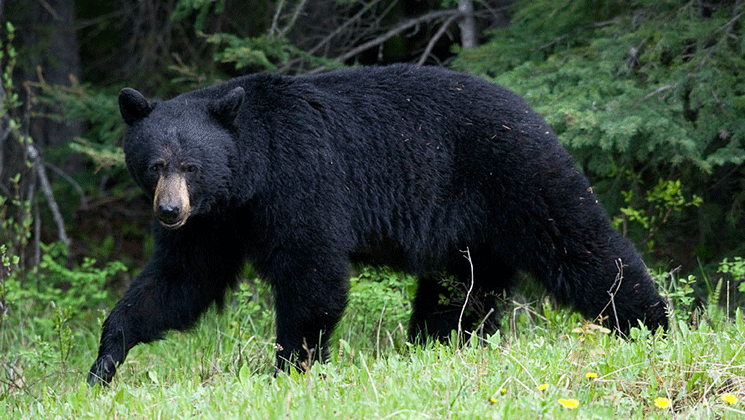

In [ ]:
img = open_image(path/'black'/'00000021.jpg')
img

In [ ]:
classes = ['black', 'grizzly', 'teddys']
data2 = ImageDataBunch.single_from_classes(path, classes, tfms=get_transforms(), size=224).normalize(imagenet_stats)
learn = create_cnn(data2, models.resnet34)
learn.load('stage-2')

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
pred_class

'black'

So you might create a route something like this ([thanks](https://github.com/simonw/cougar-or-not) to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(cat_learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```

(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.)

## Things that can go wrong

- Most of the time things will train fine with the defaults
- There's not much you really need to tune (despite what you've heard!)
- Most likely are
  - Learning rate
  - Number of epochs

### Learning rate (LR) too high

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [ ]:
learn.fit_one_cycle(1, max_lr=0.5)

Total time: 00:13
epoch  train_loss  valid_loss  error_rate       
1      12.220007   1144188288.000000  0.765957    (00:13)



### Learning rate (LR) too low

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Previously we had this result:

```
Total time: 00:57
epoch  train_loss  valid_loss  error_rate
1      1.030236    0.179226    0.028369    (00:14)
2      0.561508    0.055464    0.014184    (00:13)
3      0.396103    0.053801    0.014184    (00:13)
4      0.316883    0.050197    0.021277    (00:15)
```

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-5)

Total time: 01:07
epoch  train_loss  valid_loss  error_rate
1      1.349151    1.062807    0.609929    (00:13)
2      1.373262    1.045115    0.546099    (00:13)
3      1.346169    1.006288    0.468085    (00:13)
4      1.334486    0.978713    0.453901    (00:13)
5      1.320978    0.978108    0.446809    (00:13)



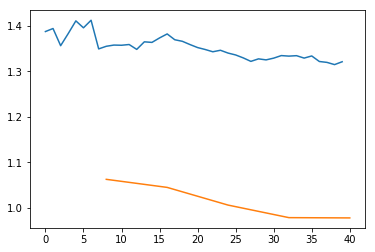

In [ ]:
learn.recorder.plot_losses()

As well as taking a really long time, it's getting too many looks at each image, so may overfit.

### Too few epochs

In [ ]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, pretrained=False)

In [ ]:
learn.fit_one_cycle(1)

Total time: 00:14
epoch  train_loss  valid_loss  error_rate
1      0.602823    0.119616    0.049645    (00:14)



### Too many epochs

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.9, bs=32, 
        ds_tfms=get_transforms(do_flip=False, max_rotate=0, max_zoom=1, max_lighting=0, max_warp=0
                              ),size=224, num_workers=4).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate, ps=0, wd=0)
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(40, slice(1e-6,1e-4))

Total time: 06:39
epoch  train_loss  valid_loss  error_rate
1      1.513021    1.041628    0.507326    (00:13)
2      1.290093    0.994758    0.443223    (00:09)
3      1.185764    0.936145    0.410256    (00:09)
4      1.117229    0.838402    0.322344    (00:09)
5      1.022635    0.734872    0.252747    (00:09)
6      0.951374    0.627288    0.192308    (00:10)
7      0.916111    0.558621    0.184982    (00:09)
8      0.839068    0.503755    0.177656    (00:09)
9      0.749610    0.433475    0.144689    (00:09)
10     0.678583    0.367560    0.124542    (00:09)
11     0.615280    0.327029    0.100733    (00:10)
12     0.558776    0.298989    0.095238    (00:09)
13     0.518109    0.266998    0.084249    (00:09)
14     0.476290    0.257858    0.084249    (00:09)
15     0.436865    0.227299    0.067766    (00:09)
16     0.457189    0.236593    0.078755    (00:10)
17     0.420905    0.240185    0.080586    (00:10)
18     0.395686    0.255465    0.082418    (00:09)
19     0.373232    0.2